# Television Network Analysis

## Jon Dickerson / Luca Belli




In [67]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


The data set is downloaded and cleaned using the shell script in the root directory. 

It does two things:
- Curls the data from the IMDB ftp server
- Cleans it up by calling the two scripts also in the directory
  - `parseRawFiles.py` parses the data (a la Brandon Rhodes tut)
  - `combineData.py` joins and filters the data and makes the final data set

In [68]:
main_data = pd.read_csv('../data/mainData.csv')
main_data.head(1)

,title,year,episode_name,season,episode_num,country,date,rating,votes,rank,name,type
0,$#*! My Dad Says,2010,Code Ed,1,4,USA,2010-10-14,6.8,72,6.899713,Alison (V) Brown,writer


We want a graph with enough nodes to be interesting, but not so many that it's unintelligible. With that in mind, lets take the top 100 shows.

In [69]:
show_ratings = main_data.groupby('title')['rank'].mean()
top_100 = list(show_ratings.sort_values(ascending=False).head(100).index)

# print the top 10
top_100[0:10] 

['Sherlock',
 'Game of Thrones',
 'Breaking Bad',
 'True Detective',
 'Better Call Saul',
 'Daredevil',
 'The Walking Dead',
 'Mr. Robot',
 'The Flash',
 'Fargo']

A small caveat here. I have calculated rank by using IMDB's formula, which it uses to list the top 250 movies on IMDB.com. I have found that I don't really agree with many of the ratings. To have both "The Sopranos" and "The Wire" out of the top 10 is mind-boggling (as a fan of those shows). However, I have decided to put fandom aside and continue using IMDB's rank.

### Original Scope

Originally, I had planned to make a network of writers, which would be connected by an edge if they'd written an episode of a show together. For example, here is the network for South Park.

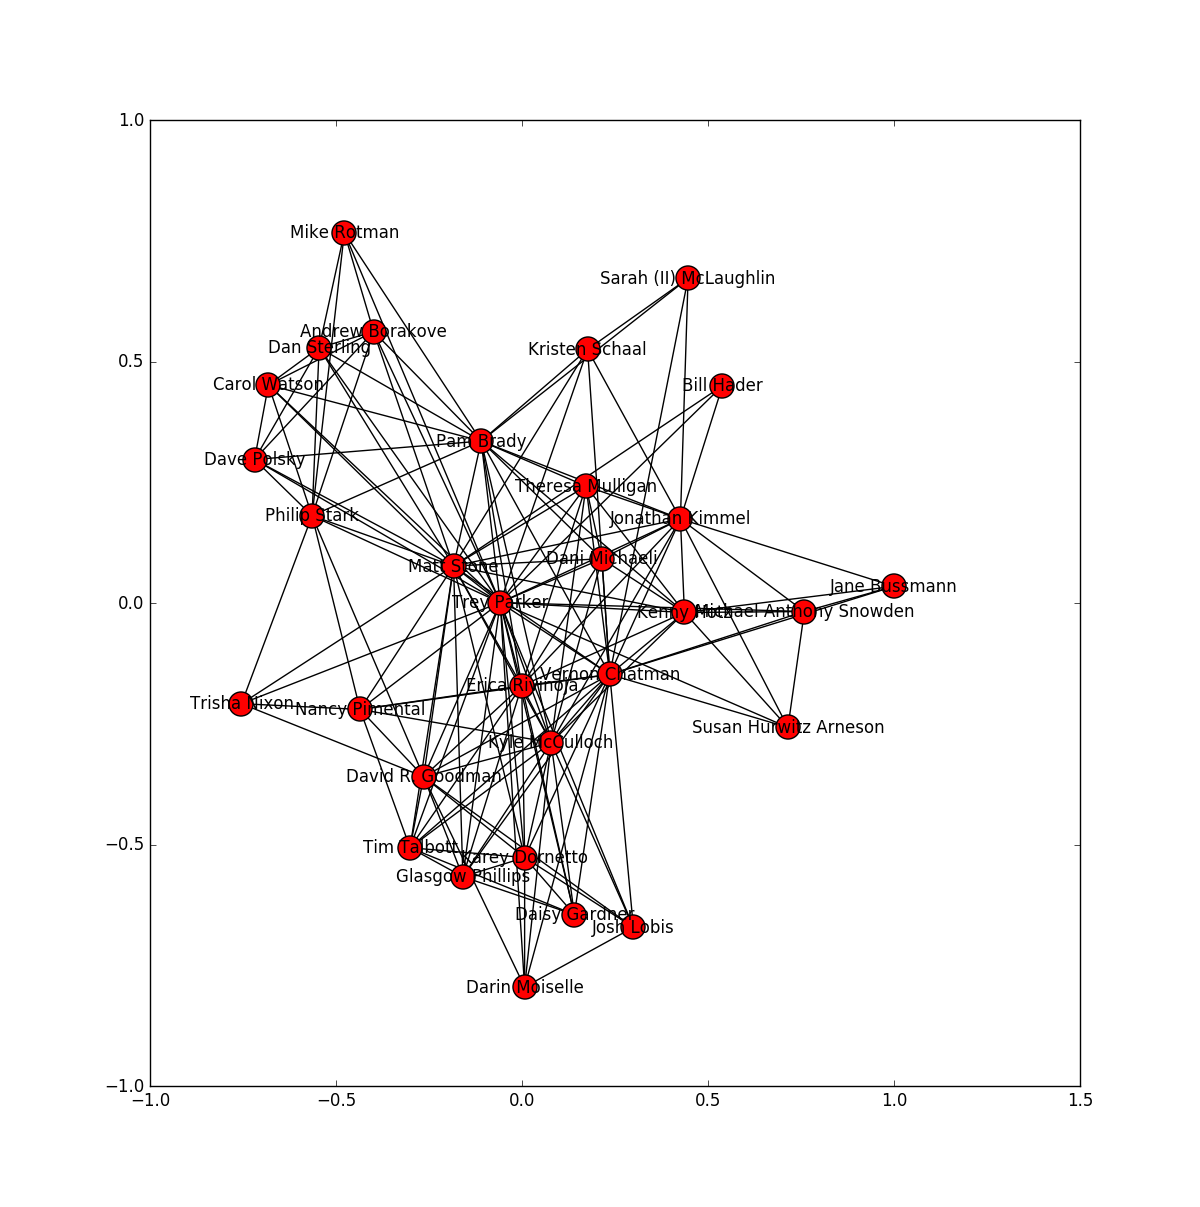

In [70]:
from IPython.display import Image

south_park = Image(filename=("../figures/SouthPark.png"))
south_park

Pretty interesting, but that's only one show. "The Sopranos" launched the careers of a few writers, and propelled others to much greater careers than they had previously. For instance, "Mad Men" creator Matthew Weiner wrote for "The Sopranos", along with "Boardwalk Empire" and "Vinyl" creator Terence Winter. Let's see the graph of "Boardwalk Empire", "Mad Men", and "The Sopranos".

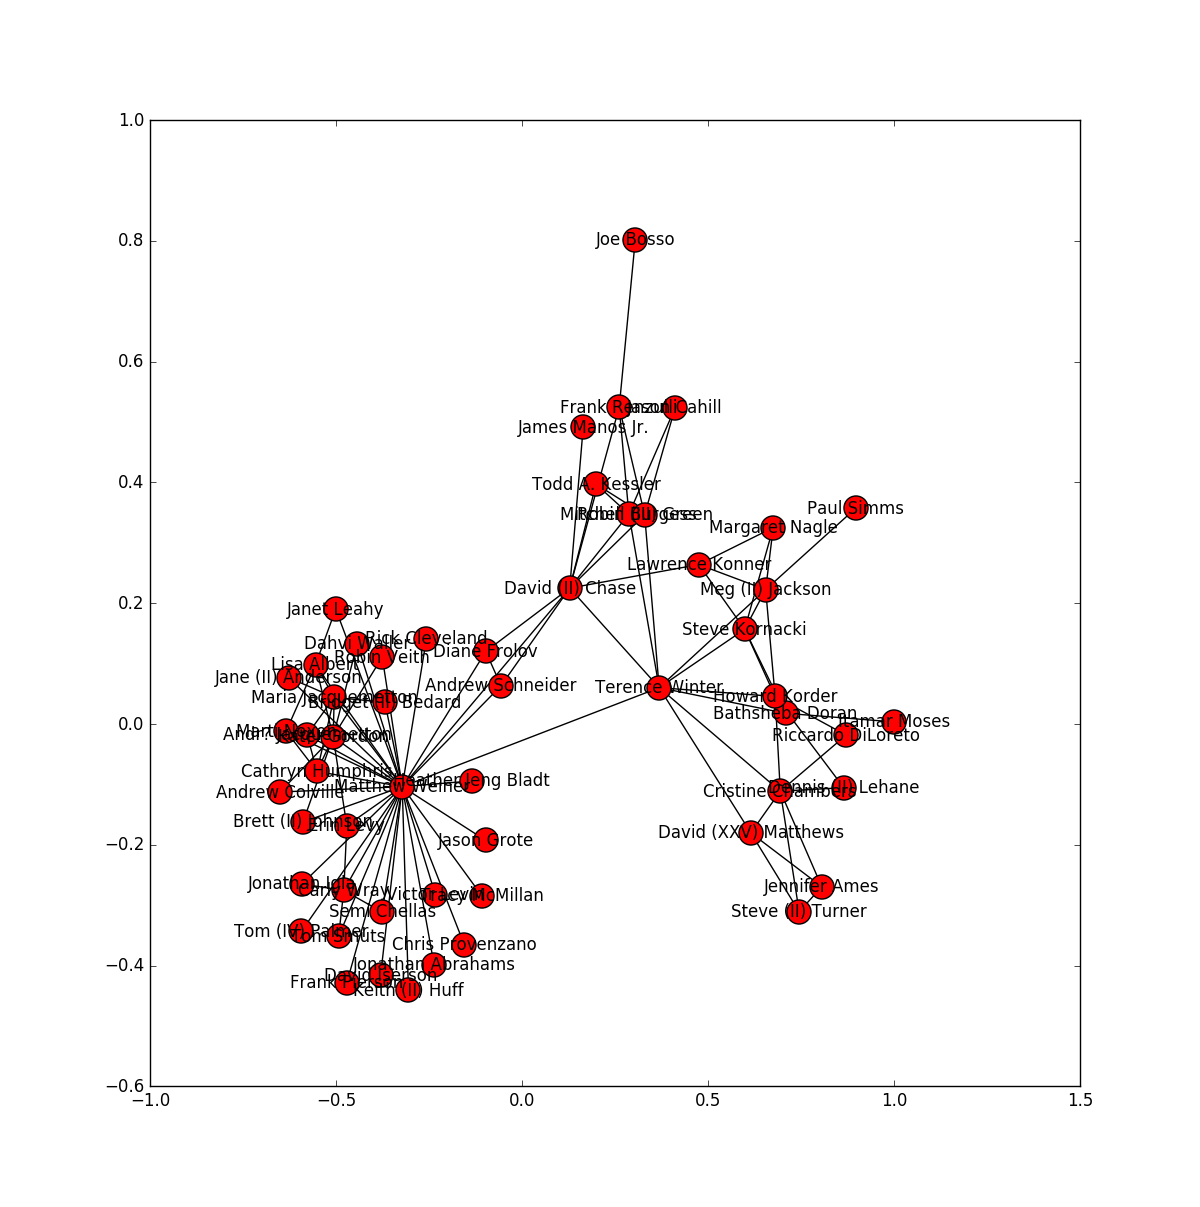

In [71]:
from IPython.display import Image

sop_be_mm = Image(filename=("../figures/SopranosBoardwalkMadmen.png"))
sop_be_mm

What's really interesting about this graph is that you can see the differences in the structures of the clusters corresponding to the different shows. Take "Mad Men", for instance. Matthew Weiner is at the center of that hub-and-spoke network on the bottom left. In network analysis, this is called an ego-centric network. That's appropriate, since Matthew Weiner is notorious for rewriting all the scripts he gets.

Pretty cool, but what was quickly apparent, is that there were far too many writers to produce an intelligible graph at anything other than micro scale such as this. However, what if we took the clusters above and made _them_ the nodes, and edges connect shows if they share a common writer?

### Creating the Graph

To create the new graph, we're going to need to find shows that share a writer. To do that, we group the data set by writer, and run combinations for every show that they've written for. We can weight the edges by how many writers the two shows share.

In [72]:
# group by writer
grouped = main_data[main_data.title.isin(top_100)].groupby(['name'])

from itertools import combinations
from collections import Counter

output = []

# For ever writer, take all the combinations of show they've written for
# And deduplicate it using set()
for name, data in grouped:
    output.extend(set([x for x in combinations(data['title'],2) 
                           if x[0] != x[1]]))     # Can't match yourself

# Run a counter to help with weights later
output.sort()
c = Counter(output)

# loop through and get weights
graph_builder = []
for x in c:
    graph_builder.append((x[0], x[1], {'weight': c[x]}))


We can print an example of the `graph_builder` list to see what the items in it are.

In [73]:
graph_builder[0]

('Extras', 'The Office', {'weight': 2})

Now we can create the graph. But wait! A bug. If a show is completely isolated, i.e., shares no writers with another show, then it will be absent from this graph (because it had no combinations that weren't self-matched). So we make another quick loop through to include them as well.

In [74]:
# Create graph
G = nx.Graph()

# Add edges (and thus nodes) from the graph_builder
G.add_edges_from(graph_builder)

# Add disconnected shows
for x in top_100:
    if x not in G.nodes():
        G.add_node(x)

We now have our networkx graph object, which we can use to query our data. For instance, we can list nodes.

In [75]:
G.nodes()[:10]

['Hillbilly Horror Show',
 'Community',
 'Agent Carter',
 'Boardwalk Empire',
 'How I Met Your Mother',
 'True Blood',
 'The Big Bang Theory',
 'Mr. Robot',
 'The Walking Dead',
 'House M.D.']

And we can list edges. Not particularly exciting stuff, but it's all in the object.

In [76]:
G.edges()[:10]

[('Community', 'Modern Family'),
 ('Community', 'Rick and Morty'),
 ('Community', 'Arrested Development'),
 ('Community', 'South Park'),
 ('Community', 'Parks and Recreation'),
 ('Agent Carter', 'Arrow'),
 ('Agent Carter', 'Daredevil'),
 ('Agent Carter', 'Firefly'),
 ('Agent Carter', 'Agents of S.H.I.E.L.D.'),
 ('Agent Carter', 'Castle')]

### Plotting the Graph

To get a sense of the structure of the graph, we can plot it.

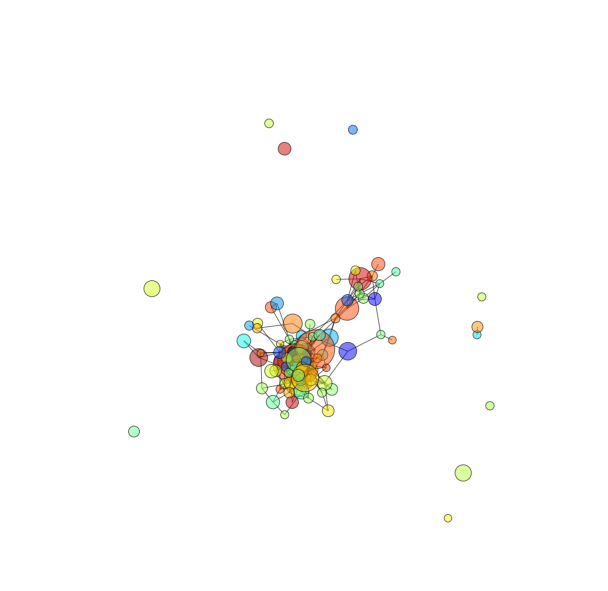

In [77]:
from collections import defaultdict

node_list = defaultdict(str)

top_10 = top_100[:10]
shows = main_data[main_data.title.isin(top_100)].groupby('title')

for x in [show[0] for show in shows]:
    if x in top_10:
        node_list[x] = x
    else:
        node_list[x] = ''
        
plt.figure(figsize=(10, 10))

pos=nx.spring_layout(G, k=0.15)

nx.draw_networkx(G, 
                 pos, 
                 alpha=0.5,
                 nodelist=node_list.keys(),
                 node_size = [show[1]['votes'].mean()/10 for show in shows],
                 node_color = [show[1]['rating'].mean()/10 for show in shows], 
                 with_labels=False)
# nx.draw_networkx_labels(G, pos, labels=node_list)  can uncomment for lables (they're ugly)
plt.axis('off')
plt.show()

That's nice to give us the overall structure of the network, which is highly clustered with some loner shows around the outside. The size of the nodes are their "hype-factor", which I use total ratings received on IMDB.com to define. The color is their rating. To get a better idea of what's going on, we can zoom in on the cluster.

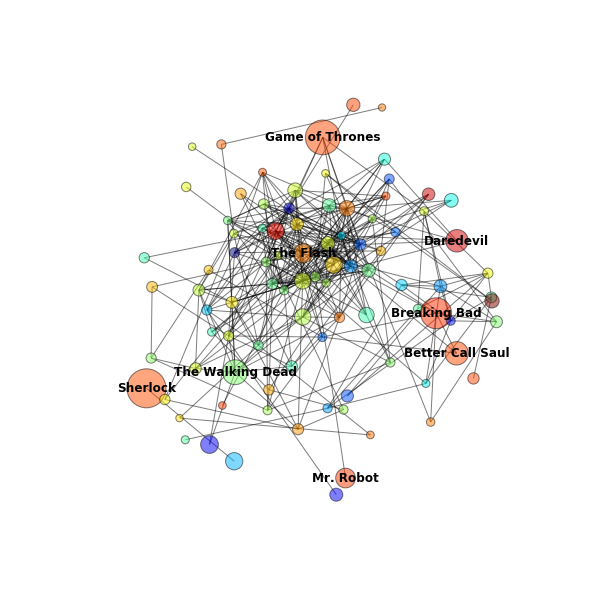

In [78]:
plt.figure(figsize=(10, 10))


connected_shows = [show[0]  for show in shows if G.degree(show[0]) > 0]

sizes = {}
for x in connected_shows:
    sizes[x] = (float(main_data.loc[main_data['title'] == x, ['votes']].mean()),
                float(main_data.loc[main_data['title'] == x, ['rating']].mean()))

unconnected_shows = set([show[0] for show in shows]) - set(connected_shows)

G.remove_nodes_from(unconnected_shows)
for x in unconnected_shows:
    node_list.pop(x)


pos=nx.spring_layout(G, k=0.8)

nx.draw_networkx(G, 
                 pos,
                 alpha=0.5,
                 nodelist=sizes.keys(),
                 node_size = [x[0]/10 for x in sizes.values()],
                 node_color = [x[1]/10 for x in sizes.values()], 
                 with_labels=False)
nx.draw_networkx_labels(G, pos, labels=node_list, font_weight='bold')
plt.axis('off')
plt.show()

We can see that the top 100 shows (which isn't _that_ many that you'd think they have to be) are highly connected. The TV writers of the world aren't one-hit wonders. The number of edges connected to a node is called its _degree_, as we can see above, there are several nodes which are quite high degree. I take a deeper look at degree and other network-theoretic measures in the notebook entitled 'Network Analysis'.


## Takeaways

As the saying goes: "It's not what you know, it's who." We can see that quite plainly among the writers in television. As we can see from the visualizations, the writers of television programs quite rarely work on just one show. Many of the writers work on many, and many shows share the same pool of writers. There are some showrunners that find great talent and give them their start, eventually sending them on there way to create or write on their own shows (this would be a high-degree show mentioned above). Analyzing the structure of the network like this can help to identify trends in the television world, along with particular writers that have good ideas. As a producer or television executive, being able to see this network can allow you to see potentially untapped markets, as areas with high connectedness (many nodes connected to one another in a cluster) would probably be at or near their zenith creatively, and new ground could be broken in less connected areas.